# Visualisation for clusters of an article 
 This notebook Visualises and compares change object as clustered according to **Bykau et. al** and using **Word2vec** for an article. Given an **article_name** it shows creation and deletion portion of each clusters along with showing revision_id editor and time as index.

In [1]:
import sys
import os
import pickle
from string import punctuation
from string import whitespace


import matplotlib.pyplot as plt
from IPython.display import HTML

from ipywidgets import interact, interactive, fixed, interact_manual, HBox

import ipywidgets as widgets
import pandas as pd
import numpy as np

sys.path.append("../")


In [2]:
table_style =     [
    {'selector': 'table', 'props': [('border', "6px double #696969")]},
    {'selector': 'th', 'props': [('border', "2px solid #D3D3D3"), ("font-size", "100%")]},
    {"selector":".data", "props":[("text-align", "justify"), ('border', "1px solid #000"), ('margin', '4px 24px 4px 24px' ), ("font-size", "8pt")]}
] 

deleted_token_style = {"color":"red", "font-weight": "bold","font-size": "100px"}
inserted_token_style = {"color":"blue", "font-weight": "bold","font-size": "100px"}

In [3]:
with open("../../wordvectors/vocabs.pkl", "rb") as file:
    vocab = pickle.load(file)


In [4]:
### getting the vlaue of the article to visualise data.
article_name = "Truth"

### We first read and visualise the clusters done using vectors prepeared by Using pre trained word2vec vector.

Word tokens in change objects are converted into vector space by using 300 dimensions of pre-trained fast text pre trained embedding vectors. Size of the vocobulary loaded is 1 million words.

Each change object is represented by concatinating  vectors representing left neighbour tokens, insert and delete tokens and right neighbour tokens. Insert and delete tokens vectors is average of fast-text vector representation of each words in token. Left and right neighbours are prepared by taking weighted average of vectors representated by word2vec embeddings. Weights are created by a exponential decay functions whose parameter is  neighbouring token's distance from inserted and deleted word.


#### Reading change object

In [5]:
change_object_dir = "../data/change objects/"
content_file = article_name + "_change.h5"
change_object_path = os.path.join(change_object_dir, content_file)

with pd.HDFStore(change_object_path, 'r') as store:
    #retrieving all rev list and change object from file
    change_df = store.get("data")
change_df.shape

(31777, 12)

## Remove bigger change object.

In [6]:
change_df["ins_length"]= change_df["ins_tokens"].apply(lambda x: len(x))
change_df["del_length"]= change_df["del_tokens"].apply(lambda x: len(x))

optimised_change_object_mask = ((change_df["ins_length"] <= 20 ) & (change_df["del_length"] <= 20))

optimised_df = change_df[optimised_change_object_mask].copy()

optimised_df.shape

(25193, 14)

### Make left, ins and delete string for visualisation

In [7]:
change_df["ins_token_len"] = change_df["ins_tokens"].str.len()
change_df["del_token_len"] = change_df["del_tokens"].str.len()

##### Reading revision clusters.

In [8]:
cluster_dir = "../data/clusters/"
file_name = article_name + "_optimised_cluster.h5"

change_dataframe_path = os.path.join(cluster_dir,file_name)

with pd.HDFStore(change_dataframe_path, 'r') as store:
    optimised_cluster_df = store.get("cluster")

In [9]:
cluster_dir = "../data/clusters/"
file_name = f"{article_name}_cluster.h5"
change_dataframe_path = os.path.join(cluster_dir,file_name)

with pd.HDFStore(change_dataframe_path, 'r') as store:
    cluster_df = store.get("cluster")

##### Merging change object with its clusters

In [10]:
change_df_with_clusters = pd.concat([change_df, cluster_df], axis=1)
change_df_with_clusters["edited_tokens"] = change_df_with_clusters["ins_tokens"] + change_df_with_clusters["del_tokens"]


optimised_df_with_clusters = pd.concat([optimised_df, optimised_cluster_df], axis=1)
optimised_df_with_clusters["edited_tokens"] = optimised_df_with_clusters["ins_tokens"] + optimised_df_with_clusters["del_tokens"]



## Finding relative positions of change object

In [11]:
content_dir = "../data/content/"
content_file = article_name + ".h5"
content_path = os.path.join(content_dir, content_file)
len_file = article_name + "_rev_len.h5"
len_file_path = os.path.join(content_dir, len_file)
rev_len_df = pd.read_hdf(len_file_path, key = "rev_len")

# rev_len_df = pd.DataFrame({"rev_id":rev_list[:-1], "length": rev_len_list[:-1]})


# with pd.HDFStore(content_path, 'r') as store:
#     #retrieving all rev list and change object from file
#     rev_list = store.get("rev_list")["id"].values.tolist()
#     keys = ["r" +  str(rev) for rev in rev_list]
#     rev_len_list = [store.get(key).shape[0] for key in keys]

In [12]:
rev_len_df.to_hdf(len_file_path, "rev_len")

In [13]:
optimised_df_with_clusters = optimised_df_with_clusters.reset_index().set_index('from revision id')
optimised_df_with_clusters = optimised_df_with_clusters.join(rev_len_df.set_index("rev_id"))
optimised_df_with_clusters.index.name = "from revision id"
optimised_df_with_clusters["relative_position"] =(optimised_df_with_clusters["left_neigh"]+1)/(optimised_df_with_clusters["length"])

In [14]:
# optimised_df_with_clusters["timestamp"] = optimised_df_with_clusters["timestamp"].astype('datetime64[ns]')
# optimised_df_with_clusters[["relative_position", "timestamp"]].plot()
# plt.yscale("log")
# plt.scatter(optimised_df_with_clusters["relative_position"],optimised_df_with_clusters[ "timestamp"])
# optimised_df_with_clusters[ "timestamp"]=pd.datetime(optimised_df_with_clusters["timestamp"])

(0, 1)

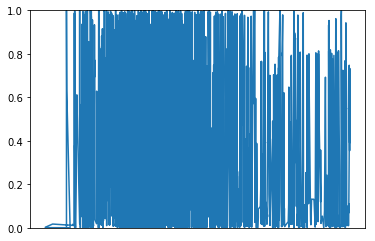

In [15]:
plt.plot(optimised_df_with_clusters["timestamp"].astype('datetime64[ns]'),  optimised_df_with_clusters["relative_position"], linestyle="-")
plt.xscale("log")
plt.ylim([0,1])

In [171]:
#optimised_df_with_clusters["cluster_4_backup"] = optimised_df_with_clusters["cluster_4"]
optimised_df_with_clusters["cluster_4"] = optimised_df_with_clusters["cluster_4_weighted"]
#optimised_df_with_clusters["cluster_4"] = optimised_df_with_clusters["cluster_4_backup"]

#### Grouping clusters and making html of each groups

In [172]:
# def find_freq_vocab_words( x, vocab):
#     freq = pd.Series(np.concatenate(x.values, axis=0)).value_counts(ascending=False)
#     return freq.loc[freq.index.intersection(vocab)]
# v = set(vocab)
# edited_tokens_freq_per_group = change_grouped_by_tokens["ins_tokens"].apply(lambda x: find_freq_vocab_words(x, v))
# left_context_freq_per_group = change_grouped_by_tokens["left_token"].apply(lambda x: find_freq_vocab_words(x, v))
# right_context_freq_per_group = change_grouped_by_tokens["right_token"].apply(lambda x: find_freq_vocab_words(x, v))
vocab_set = set(vocab)

In [173]:
optimised_df_with_clusters = optimised_df_with_clusters.reset_index().set_index(["from revision id","timestamp", "level_5"])


edited_tokens_freq_per_group = optimised_df_with_clusters.set_index("cluster_4")["edited_tokens"].apply(lambda tokens: tuple(token for token in tokens if token in vocab_set)).groupby("cluster_4").apply(lambda x:  pd.Series(np.concatenate(x.values, axis=0)).value_counts(ascending=False))
left_context_freq_per_group = optimised_df_with_clusters.set_index("cluster_4")["left_token"].apply(lambda tokens: tuple(token for token in tokens if token in vocab_set)).groupby("cluster_4").apply(lambda x:  pd.Series(np.concatenate(x.values, axis=0)).value_counts(ascending=False))
right_context_freq_per_group = optimised_df_with_clusters.set_index("cluster_4")["right_token"].apply(lambda tokens: tuple(token for token in tokens if token in vocab_set)).groupby("cluster_4").apply(lambda x:  pd.Series(np.concatenate(x.values, axis=0)).value_counts(ascending=False))

In [174]:
optimised_df_with_clusters["left_string"] = optimised_df_with_clusters["left_token"].apply(lambda tokens: tuple(token for token in tokens if token.isalnum())).str.join(" ")
optimised_df_with_clusters["del_string"] = optimised_df_with_clusters["ins_tokens"].apply(lambda tokens: tuple(token for token in tokens if token.isalnum())).str.join(" ")
optimised_df_with_clusters["ins_string"] = optimised_df_with_clusters["del_tokens"].apply(lambda tokens: tuple(token for token in tokens if token.isalnum())).str.join(" ")
optimised_df_with_clusters["right_string"] = optimised_df_with_clusters["right_token"].apply(lambda tokens: tuple(token for token in tokens if token.isalnum())).str.join(" ")

# change_df["left_string"] = change_df["left_token"].str.join(" ")
# change_df["ins_string"] = change_df["ins_tokens"].str.join(" ")
# change_df["del_string"] = change_df["del_tokens"].str.join(" ")
# change_df["right_string"] = change_df["right_token"].str.join(" ")


In [175]:

optimised_df_with_clusters = optimised_df_with_clusters.assign(counter_ts=optimised_df_with_clusters.groupby(["cluster_4","from revision id"]).ngroup() + 1)


In [176]:

#repers_weighted =  optimised_df_with_clusters.groupby("cluster_4")[["left_string", "del_string", "ins_string", "right_string"]].apply(lambda x: x.style.render())
repers_weighted =  optimised_df_with_clusters.reset_index().set_index("cluster_4")[["from revision id", "level_5", "counter_ts", "timestamp", "relative_position", "left_string", "del_string", "ins_string", "right_string"]]#.apply(lambda x: x.style.render())
optimised_df_with_clusters = optimised_df_with_clusters.reset_index().set_index(["from revision id", "level_5"])

change_grouped_by_tokens = optimised_df_with_clusters.groupby("cluster_4")



### Ranking
###### Ranking clustered groups on following parameters.
1. Size of clusters
2. No of unique editors is clusters
3. Total period of cluster. i.e difference between start and end date.
4. Median length of edited token in each cluster.

In [178]:
rank_by_size = change_grouped_by_tokens.size().sort_values(ascending=False)

rank_by_uniq_editor = optimised_df_with_clusters.reset_index().groupby("cluster_4")["editor"].nunique().sort_values(ascending=False)

rank_by_period = optimised_df_with_clusters.reset_index().groupby("cluster_4")["timestamp"].apply(lambda x: x.max() - x.min()).sort_values(ascending=False)

rank_by_rate = optimised_df_with_clusters.reset_index().groupby("cluster_4")["timegap"].apply(lambda x: x.mean()).sort_values(ascending=False)

# unique_word_count_per_group = word_freq_per_group.groupby("cluster_4_weighted").apply(lambda x: x.index.shape[0]).sort_values(ascending=False)

## Visualisation for change object clustered on neighbour vectors

Following visualisation can be used to compare with above visualisation which is using neighbour vectors to cluster.



In [200]:
count = 100
def plot_freq(gap_freq, left_context_freq, right_context_freq, timestamp, relative_position, number=100):
    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(35, 20))
        
    axs[0].barh( left_context_freq.index[:count][::-1], left_context_freq.values[:count][::-1])
    axs[0].set_title(" frequency plot of top 100 words in left context")
    axs[0].set_xlabel("frequency")
    axs[0].set_ylabel("unique words in left context ")
    
    axs[1].barh( gap_freq.index[:count][::-1], gap_freq.values[:count][::-1])
    axs[1].set_title(" frequency plot of top 100 words in gap")
    axs[1].set_xlabel("frequency")
    axs[1].set_ylabel("unique words in gap ")
    
    axs[2].barh( right_context_freq.index[:count][::-1], right_context_freq.values[:count][::-1])
    axs[2].set_title(" frequency plot of top 100 words in right context")
    axs[2].set_xlabel("frequency")
    axs[2].set_ylabel("unique words in right context ")
    
    fig2, ax = plt.subplots(nrows=1, ncols=1,figsize=(35, 20))
    ax.scatter( timestamp, relative_position, c="red",marker="D", label = "relative position with respect to timestamp")
    ax.set_title(" Plot of timestamp with relative position")
    ax.set_xlabel("timestamp")
    ax.set_ylabel("relative position ")
    plt.ylim(0, 1)
    ax.legend()
#     axs[3].set_xscale("log")
#     axs[3].set_yscale("log")


    return fig
# _= plot_freq(edited_tokens_freq_per_group.loc[1], 
#             left_context_freq_per_group.loc[1], 
#             right_context_freq_per_group.loc[1],
#             change_grouped_by_tokens["timestamp"].get_group(2).values,
#             change_grouped_by_tokens["relative_position"].get_group(2).values
#             )

In [201]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

def display_article_content(index, change_html_series, edited_tokens_freq_per_group, left_context_freq_per_group, right_context_freq_per_group, change_grouped_by_tokens, out):
    global change_html_glob
    with out:
        out.clear_output()
        
    change_html = change_html_series.loc[index]
    
    change_html_glob = change_html
    _ = plot_freq(edited_tokens_freq_per_group.loc[index], 
            left_context_freq_per_group.loc[index], 
            right_context_freq_per_group.loc[index],
            change_grouped_by_tokens["counter_ts"].get_group(index).values,
            change_grouped_by_tokens["relative_position"].get_group(index).values)
    with out:
#         display(change_html)
        display(f"Word length distribution for {index}")
#         display(fig)
        display(change_html.set_index(["from revision id", "level_5", "timestamp", "counter_ts", "relative_position"]))
        #display(HTML(change_html))
#     return out
        

In [202]:
drop_down = list(zip(np.arange(rank_by_period.size), rank_by_period.index))

**Please rerun next cell each time page is reloaded**

In [203]:
outp = widgets.Output(layout={'border': '1px solid black'})

_=widgets.interact(display_article_content, index=drop_down, change_html_series= widgets.fixed(repers_weighted),edited_tokens_freq_per_group= widgets.fixed(edited_tokens_freq_per_group), left_context_freq_per_group= widgets.fixed(left_context_freq_per_group), right_context_freq_per_group= widgets.fixed(right_context_freq_per_group), change_grouped_by_tokens= widgets.fixed(change_grouped_by_tokens), out=widgets.fixed(outp));

interactive(children=(Dropdown(description='index', options=((0, 26), (1, 85), (2, 89), (3, 45), (4, 62), (5, …

In [146]:
#outp
change_html_glob.set_index(["from revision id", "level_5", "timestamp", "counter_ts", "relative_position"])

left_string  \
from revision id level_5 timestamp           counter_ts relative_position                                                                                                                                                                              
286436           1       2001-03-21 00:36:45 2083       0.001885           the following is a portion of                                                                                                                                               
440545           23      2002-11-23 11:57:29 2084       0.335232           the original version of this bare bones theory is called the redundancy theory of truth and it is due to f p ramsey                                                         
                 24      2002-11-23 11:57:29 2084       0.335842           original version of this bare bones theory is called the redundancy theory of truth and it is due to f p ramsey an english                                                  
442894           20      2002-11-24 18:48:03 2085       0.995692           to rest content with any sort of relativism that says that truth is just the same as belief you can do a heck of a lot better than that                                     
928657           4       2003-05-17 04:02:07 2086       0.406340           millions of stillborns are promulgating and proselytizing iggiation ignorance of the truth the fundamental truth is being raped by the ignorant ignorance will not          
                 6       2003-05-17 04:02:07 2086       0.582133           an intelligent woman you must join the fight for truth please search deep within and internalize the fear and agony that the reign of the stillborn will instill upon       
                 8       2003-05-17 04:02:07 2086       0.737752           catch cry packs of lies exist to lead us astray placed by the ignorant join the righteous fight for truth remember truth is                                                 
                 16      2003-05-17 04:02:07 2086       0.902017           www sids org uk fsid bartlett jpg i your future leader i                                                                                                                    
                 24      2003-05-17 04:02:07 2086       0.994236           click the below link for further information including an opportunity to obtain a free brochure on instilling truth in this nation thank you for your time                  
1096787          51      2003-06-30 17:21:18 2087       0.936396           at once with the post facto nature of symbolic description and the choice a community has in explaining its motives before the fact and after the fact                      
1096868          41      2003-06-30 17:59:44 2088       0.884974           the minds of people long dead or facts about very distant events perhaps there are facts about subatomic particles which we cannot in principle ever know                   
1305011          13      2003-08-17 22:32:56 2089       0.053374           any special insight one generally commits oneself to truth of this kind and does not question it further this we may call the authoritative type of truth                   
1591195          22      2003-10-19 16:30:33 2090       0.225327           one of the first four headings where you see some assertion that propaganda or authority is being over trusted it is likely that the                                        
                 34      2003-10-19 16:30:33 2090       0.644440           to some standard of evidence for some period of time thoughtful people may think of this kind of truth as something that holds for a                                        
                 72      2003-10-19 16:30:33 2090       0.225043           will fall under one of the first four headings where you see some assertion that propaganda or authority is being over trusted it is                                        
1614005          

In [ ]:
# widgets.Dropdown(
#     options=['1', '2', '3'],
#     value='2',
#     description='Number:',
#     disabled=False,
# )

### **Bykau Et. al.** change objects and its clusters

In [ ]:
bykau_dir =  "../data/bykau_change_object/"
filename =  f"{article_name}_change.h5"

change_object_file = os.path.join(bykau_dir, filename)
bykau_change_df = pd.read_hdf(change_object_file, key="data")
bykau_change_df.shape

In [ ]:
bykau_change_df = bykau_change_df.reset_index().set_index('from revision id')
bykau_change_df = bykau_change_df.join(rev_len_df.set_index("rev_id"))
bykau_change_df.index.name = "from revision id"
bykau_change_df["relative_position"] =(bykau_change_df["left_neigh"]+1)/(bykau_change_df["length"])

In [ ]:
bykau_change_df["left_string"] = bykau_change_df["left_token"].str.join(" ")
bykau_change_df["ins_string"] = bykau_change_df["ins_tokens"].str.join(" ")
bykau_change_df["del_string"] = bykau_change_df["del_tokens"].str.join(" ")
bykau_change_df["right_string"] = bykau_change_df["right_token"].str.join(" ")

#### Grouping and ranking.

In [ ]:
bykau_groups = bykau_change_df.groupby("reclustered_group")

# bykau_edited_freq = bykau_groups["ins_tokens"].apply(lambda x: find_freq_vocab_words(x, vocab))
# bykau_left_context_freq = bykau_groups["left_token"].apply(lambda x: find_freq_vocab_words(x, vocab))
# bykau_right_context_freq = bykau_groups["right_token"].apply(lambda x: find_freq_vocab_words(x, vocab))

bykau_edited_freq = bykau_groups["ins_tokens"].apply(lambda x:  pd.Series(np.concatenate(x.values, axis=0)).value_counts(ascending=False))
bykau_left_context_freq = bykau_groups["left_token"].apply(lambda x:  pd.Series(np.concatenate(x.values, axis=0)).value_counts(ascending=False))
bykau_right_context_freq = bykau_groups["right_token"].apply(lambda x:  pd.Series(np.concatenate(x.values, axis=0)).value_counts(ascending=False))


In [ ]:
bykau_rank_by_size = bykau_groups.size().sort_values(ascending=False)

bykau_rank_by_uniq_editor = bykau_change_df.reset_index().groupby("reclustered_group")["editor"].nunique().sort_values(ascending=False)

bykau_rank_by_period = bykau_change_df.reset_index().groupby("reclustered_group")["timestamp"].apply(lambda x: x.max() - x.min()).sort_values(ascending=False)

bykau_rank_by_rate = bykau_change_df.reset_index().groupby("reclustered_group")["timegap"].apply(lambda x: x.mean()).sort_values(ascending=False)

bykau_change_df = bykau_change_df.reset_index().set_index(["from revision id", "level_5"])


# unique_word_count_per_group = word_freq_per_group.groupby("cluster_4_weighted").apply(lambda x: x.index.shape[0]).sort_values(ascending=False)

#### Bykau Visualisation

THis can be used to compare with our visualisation.

In [ ]:
bykau_drop_down = list(zip(np.arange(bykau_rank_by_period.size), bykau_rank_by_period.index))

In [ ]:
repers_bykau = bykau_change_df.groupby("reclustered_group")[["left_string", "del_string", "ins_string", "right_string"]].apply(lambda x: x.style.render())

**Please rerun next cell each time page is reloaded**

In [ ]:
bykau_outp = widgets.Output(layout={'border': '1px solid black'})

# _=widgets.interact(display_article_content, index=drop_down, change_html_series= widgets.fixed(repers_bykau), out=widgets.fixed(bykau_outp));

_=widgets.interact(display_article_content, index=bykau_drop_down, change_html_series= widgets.fixed(repers_bykau),edited_tokens_freq_per_group= widgets.fixed(bykau_edited_freq), left_context_freq_per_group= widgets.fixed(bykau_left_context_freq), right_context_freq_per_group= widgets.fixed(bykau_right_context_freq), change_grouped_by_tokens= widgets.fixed(bykau_change_df.groupby("reclustered_group")), out=widgets.fixed(bykau_outp));

In [ ]:
bykau_outp

In [ ]:
# @interact( clusters_html=fixed(repers_4_neigh), group=range(groups.ngroups))
# def display_clusters(clusters_html, group):
#      return display(HTML(clusters_html.iloc[group]))

In [ ]:
# drop_down = list(zip(rev_list.id, rev_list.index))